In [1]:
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from matplotlib import gridspec
from shapely.ops import unary_union

from data_utils import get_anomaly
from meteo_utils import (
    get_wind_chill,
    get_windspeed,
    heat_index_celsius,
    kelvin_to_celsius,
    ms_to_kmh,
    relative_humidity_from_specific_humidity_and_pressure_and_temperature,
    relative_humidity_from_temperature_and_dew_point_temperature,
)

In [2]:
plt.rcParams.update({"font.size": 8})
plt.rcParams["figure.dpi"] = 300
plt.style.use("tableau-colorblind10")

alphabet_letters = np.array(
    list(map(chr, range(65, 91)))
)  # used for labelling subplots
textwidth = 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch  # textwidth in inches

get data.

In [3]:
gt_data_winterstorm = xr.open_dataset("data/2021_NA_winter_storm_gt.nc")

gt_data_pnw = xr.open_dataset("data/2021_PNW_heatwave_gt.nc")

era5_climatology = xr.open_dataset("data/2021_PNW_heatwave_climatology.nc")

gt_data_humid = xr.open_dataset("data/2023_SA_humid_heatwave_gt.nc")

# winterstorm
time_min_winterstorm = np.datetime64("2021-02-15T12:00:00.000000000")
college_station_coords = {"latitude": 30.6280, "longitude": 360 - 96.3344360}
bb_texas = {"longitude": slice(253, 267), "latitude": slice(25, 37)}

# pnw heatwave
ts = slice(
    np.datetime64("2021-06-27T00:00:00.000000000"),
    np.datetime64("2021-06-29T23:59:00.000000000"),
)

lats = np.array([49.25, 47.5, 45.5])
lons = np.array([-123, -122.25, -122.75]) % 360
labels_cities = ["Vancouver", "Seattle", "Portland"]

# humid heatwave:
box_india_bangladesh = {"latitude": slice(7, 27), "longitude": slice(72, 94)}
box_laos_thailand = {"latitude": slice(5, 23), "longitude": slice(97, 109)}

boxes = [box_india_bangladesh, box_laos_thailand]
slices = [
    slice(
        np.datetime64("2023-04-17T00:00:00.000000000"),
        np.datetime64("2023-04-20T23:00:00.000000000"),
    ),
    slice(
        np.datetime64("2023-04-18T00:00:00.000000000"),
        np.datetime64("2023-04-21T23:00:00.000000000"),
    ),
]

inner_bounds = np.array([27, 32, 41, 54])
bounds = np.array([20, 27, 32, 41, 54, 60])
colors = np.array(["#d9d9d9", "#bdbdbd", "#969696", "#636363", "#252525"])
labels = ["Low Risk", "Caution", "Extreme\nCaution", "Danger", "Extreme\nDanger"]

In [4]:
# calculate wind chill:
gt_data_winterstorm["wind_chill"] = get_wind_chill(
    T_2m=kelvin_to_celsius(gt_data_winterstorm["2m_temperature"]),
    speed_10m=ms_to_kmh(
        get_windspeed(
            u=gt_data_winterstorm["10m_u_component_of_wind"],
            v=gt_data_winterstorm["10m_v_component_of_wind"],
        )
    ),
)

In [5]:
def mean_daily_max(
    ds: xr.Dataset | xr.DataArray, dim_name: str = "time"
) -> xr.Dataset | xr.DataArray:
    """Aggregate data temporally by taking the daily maximum and averaging over dates.

    Args:
    ----
        ds (xr.Dataset | xr.DataArray): Object the temporal agregation should be applied to.
        dim_name (str, optional): Name of the dimension to apply this to. Defaults to "time".

    Returns:
    -------
        (xr.Dataset | xr.DataArray): Object with applied aggregation.

    """
    return ds.groupby(f"{dim_name}.date").max().mean(dim="date")

In [6]:
# in a slight misuse of notation, I reuse the "level" coordinate to indicate how the relative humidity has been computed, NOT where it is valid!

gt_data_humid["relative_humidity"] = xr.DataArray(
    coords=dict(gt_data_humid["2m_temperature"].coords),
    dims=list(gt_data_humid["2m_temperature"].dims),
).chunk({"time": 5})

gt_data_humid["heat_index"] = xr.DataArray(
    coords=dict(gt_data_humid["2m_temperature"].coords),
    dims=list(gt_data_humid["2m_temperature"].dims),
).chunk({"time": 5})

In [7]:
gt_data_humid["relative_humidity"].loc[{"level": -1}] = (
    relative_humidity_from_temperature_and_dew_point_temperature(
        T=kelvin_to_celsius(gt_data_humid["2m_temperature"]).sel(level=-1),
        T_d=kelvin_to_celsius(gt_data_humid["2m_dewpoint_temperature"]).sel(level=-1),
    )
)

gt_data_humid["heat_index"].loc[{"level": -1}] = heat_index_celsius(
    T=kelvin_to_celsius(gt_data_humid["2m_temperature"].sel(level=-1)),
    R=gt_data_humid["relative_humidity"].sel(level=-1),
)


gt_data_humid["relative_humidity"].loc[{"source": "ERA5", "level": 1000}] = (
    relative_humidity_from_specific_humidity_and_pressure_and_temperature(
        q=gt_data_humid.sel({"source": "ERA5", "level": 1000})["specific_humidity"],
        p=1000,
        T=kelvin_to_celsius(
            gt_data_humid.sel({"source": "ERA5", "level": 1000})["temperature"]
        ),
    )
)
gt_data_humid["relative_humidity"].loc[{"source": "HRES_t0", "level": 1000}] = (
    relative_humidity_from_specific_humidity_and_pressure_and_temperature(
        q=gt_data_humid.sel({"source": "HRES_t0", "level": 1000})["specific_humidity"],
        p=1000,
        T=kelvin_to_celsius(
            gt_data_humid.sel({"source": "HRES_t0", "level": 1000})["temperature"]
        ),
    )
)

gt_data_humid["heat_index"].loc[{"source": "ERA5", "level": 1000}] = heat_index_celsius(
    T=kelvin_to_celsius(gt_data_humid["2m_temperature"].sel(source="ERA5", level=-1)),
    R=gt_data_humid["relative_humidity"].sel(source="ERA5", level=1000),
)
gt_data_humid["heat_index"].loc[{"source": "HRES_t0", "level": 1000}] = (
    heat_index_celsius(
        T=kelvin_to_celsius(
            gt_data_humid["2m_temperature"].sel(source="HRES_t0", level=-1)
        ),
        R=gt_data_humid["relative_humidity"].sel(source="HRES_t0", level=1000),
    )
)

/home/wider/.conda/envs/climate_eval/lib/python3.13/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/wider/.conda/envs/climate_eval/lib/python3.13/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/wider/.conda/envs/climate_eval/lib/python3.13/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [8]:
# load shapefiles.

# downloaded from https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/information/
shapefile_countries = "Shapefiles/countries.geojson"

# downloaded from https://datacatalog.worldbank.org/search/dataset/0042325
shapefile_climate_zones = "Shapefiles/climate_zones/c1976_2000_0/c1976_2000.shp"  # http://koeppen-geiger.vu-wien.ac.at/data/legend.txt

shp_climate = gpd.read_file(shapefile_climate_zones)
shp_countries = gpd.read_file(shapefile_countries)


# masks
def clip_data(data, mask):
    data.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)
    data.rio.write_crs(
        "epsg:4326", inplace=True
    )  # this is the standard crs (Coordinate Reference System)
    return data.rio.clip(mask.geometry, mask.crs, drop=False)


laos_mask = shp_countries[
    shp_countries["french_short"] == "République démocratique populaire lao"
].geometry
thailand_mask = shp_countries[shp_countries["french_short"] == "Thaïlande"].geometry
laos_thailand_mask = gpd.GeoDataFrame(
    geometry=[unary_union([laos_mask, thailand_mask])]
)

india_mask = shp_countries[shp_countries["french_short"] == "Inde"].geometry
bangladesh_mask = shp_countries[shp_countries["french_short"] == "Bangladesh"].geometry
india_bangladesh_mask = gpd.GeoDataFrame(
    geometry=[unary_union([india_mask, bangladesh_mask])]
).set_crs("epsg:4326")

# we want to excluded climate zones that are not affected by the dry humid heat wave. Therefore we restrict the valid classes to ones in Köppen-Geiger Class A (Tropical), similar to what WWA did.

cutout = gpd.GeoDataFrame(
    geometry=[
        unary_union(
            shp_climate[shp_climate["GRIDCODE"].isin(np.arange(10, 21))]
            .to_crs("epsg:4326")
            .geometry
        )
    ]
).set_crs("epsg:4326")
mp = india_bangladesh_mask.geometry.intersection(
    cutout, align=True
).to_numpy()[
    0
]  # only select the largest polygon - there are quite a lot of small left over ones that get produced
india_bangladesh_climate_mask = gpd.GeoDataFrame(
    geometry=[max(mp.geoms, key=lambda polygon: polygon.area)]
).set_crs("epsg:4326")
masks = [india_bangladesh_climate_mask, laos_thailand_mask]

# plot

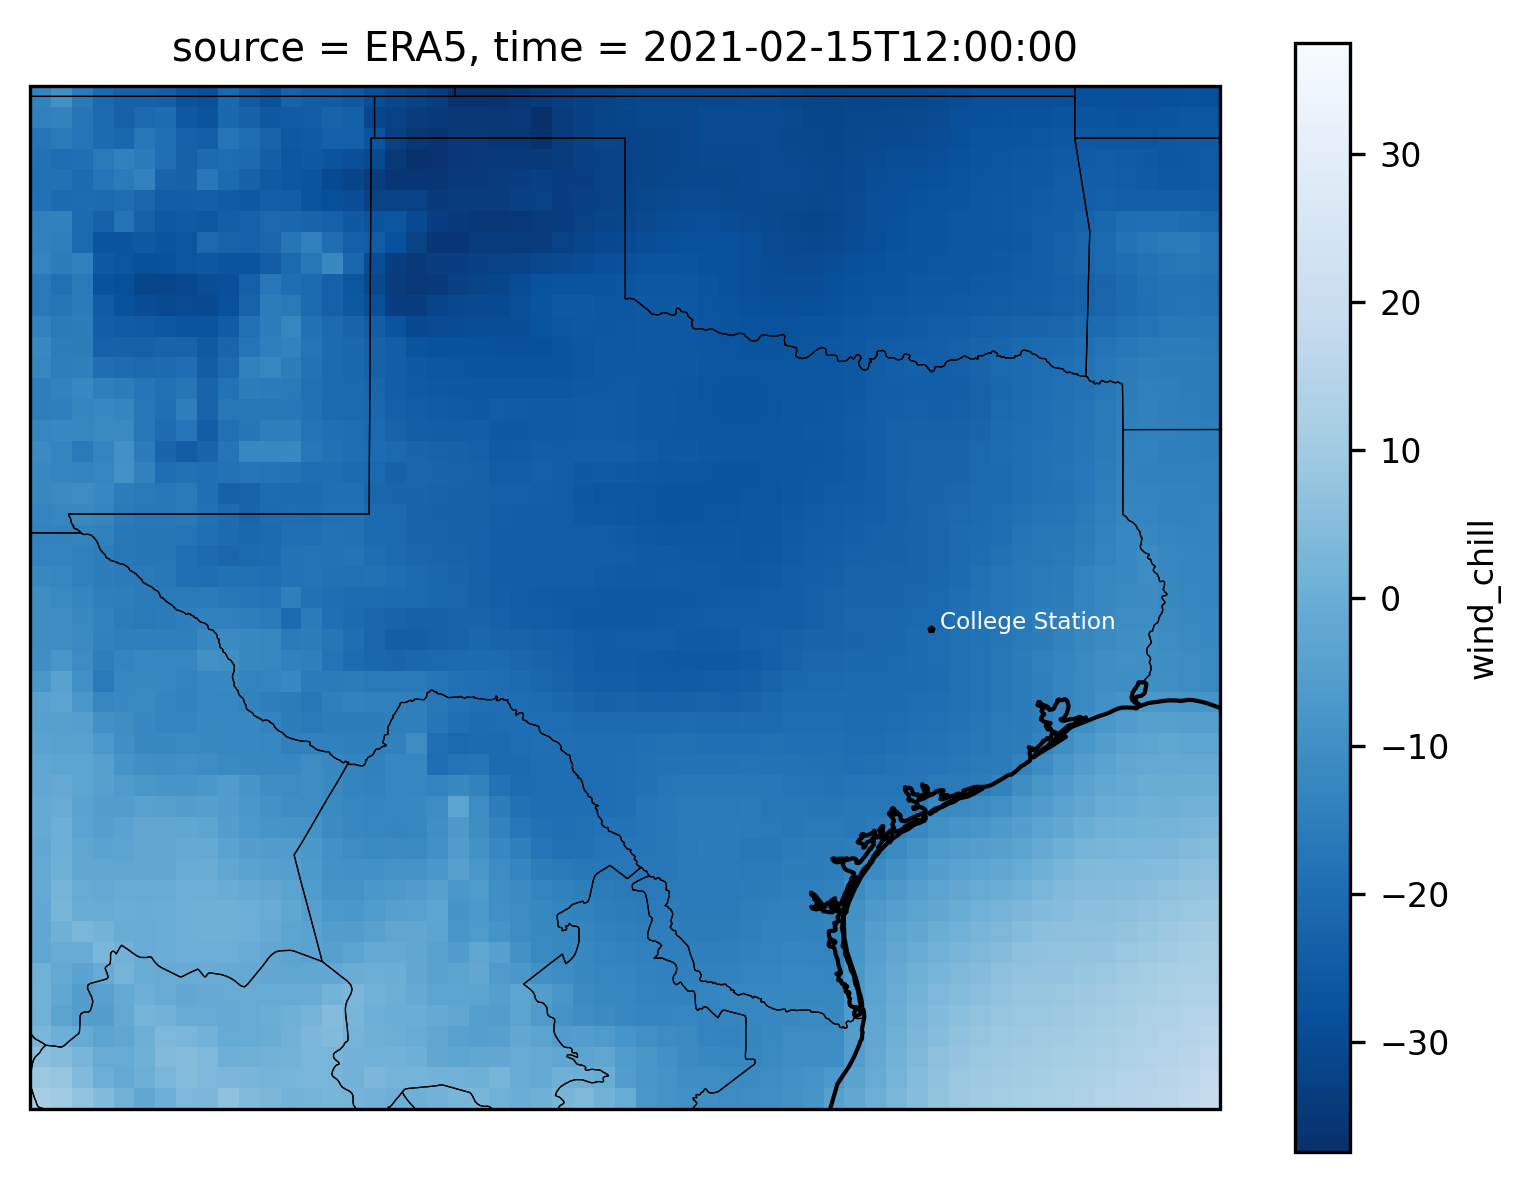

In [9]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})


map_ws = (
    gt_data_winterstorm["wind_chill"]
    .sel(bb_texas)
    .sel(source="ERA5")
    .sel(time=time_min_winterstorm)
    .plot(ax=ax, cmap="Blues_r")
)  # .sel(bb_texas)

ax.scatter(*reversed(list(college_station_coords.values())), s=1, marker="*", c="k")

ax.annotate(
    "College Station",
    [college_station_coords["longitude"] + 0.1, college_station_coords["latitude"]],
    transform=ccrs.PlateCarree(),
    fontsize="x-small",
    color="white",
    zorder=np.inf,
)

ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

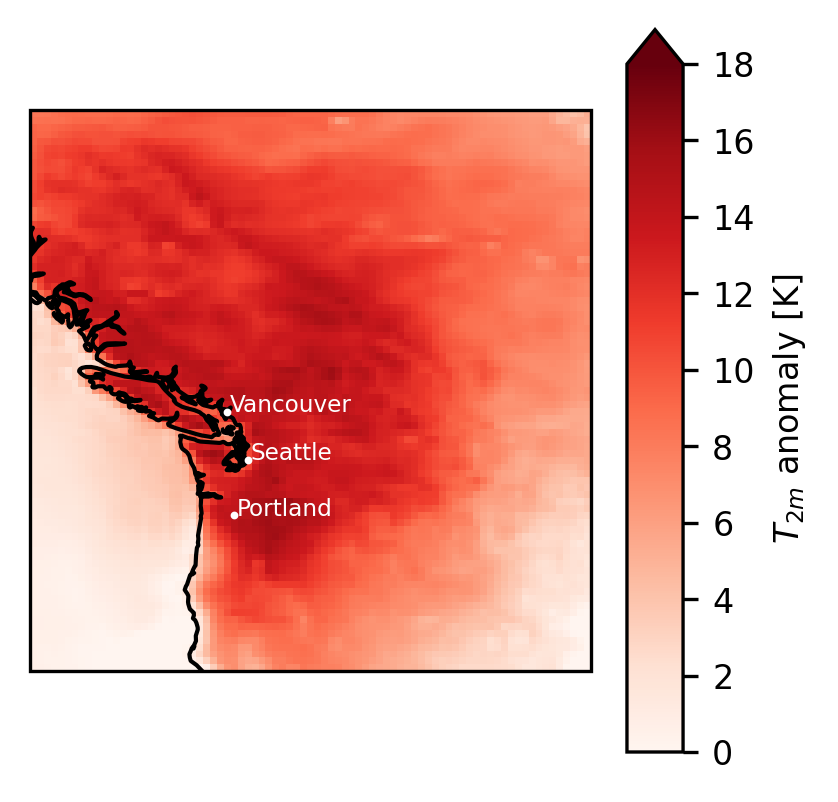

In [10]:
levels = np.arange(-18, 20, 2)

aspect_ratio_single_plot = 1
fig = plt.figure(figsize=(textwidth / 2, textwidth / 2 / aspect_ratio_single_plot))
gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=(1, 0.1))

anomaly_ERA5 = get_anomaly(
    da=gt_data_pnw.sel(source="ERA5")["2m_temperature"],
    climatology=era5_climatology,
    ts=ts,
)

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot(ax=ax_era5, add_colorbar=False, cmap="Reds", vmin=0, vmax=18)
)

ax_era5.coastlines()
ax_era5.set_title("")

ax_era5.scatter(
    lons,
    lats,
    transform=ccrs.PlateCarree(),
    c="w",
    marker=".",
    s=3,
    zorder=np.inf,
)

for i, text in enumerate(labels_cities):
    ax_era5.annotate(
        text,
        (lons[i] + 0.1, lats[i]),
        transform=ccrs.PlateCarree(),
        fontsize="x-small",
        color="white",
        zorder=np.inf,
    )

ax_cbar = fig.add_subplot(gs[0, 1])

plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly [K]",
    orientation="vertical",
    extend="max",
)

fig.suptitle("")
plt.tight_layout()
plt.savefig("images/2021_PNW_heatwave_anomalies_visual.png")
plt.show()

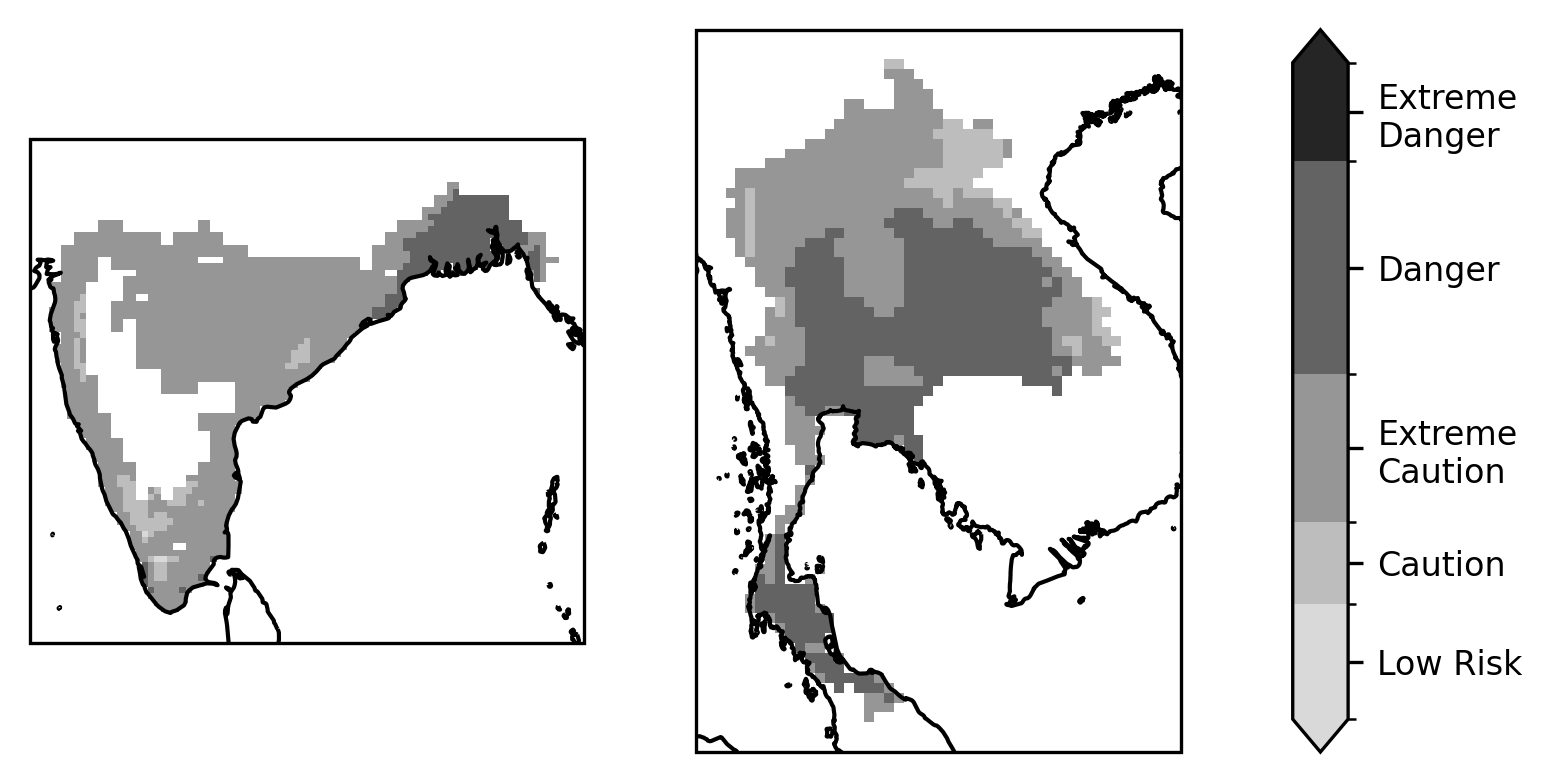

In [11]:
# plot ERA5 stats.

aspect_ratio_single_plot = 0.8

fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot * 3 / 2))

gs = gridspec.GridSpec(3, 3, figure=fig, width_ratios=[1, 1, 0.1])

for i, (box, time_slice, mask) in enumerate(zip(boxes, slices, masks, strict=True)):
    mean_hi_daily_max = mean_daily_max(
        gt_data_humid["heat_index"]
        .sel(source="ERA5", level=1000)
        .sel({"time": time_slice, **box})
    )

    # heat index danger levels
    ax = fig.add_subplot(gs[2, i], projection=ccrs.PlateCarree())
    cmap = matplotlib.colors.ListedColormap(colors)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    ticks = (bounds[1:] - bounds[:-1]) / 2 + bounds[:-1]
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

    im_hi_classes = clip_data(mean_hi_daily_max, mask=mask).plot(
        ax=ax,
        cmap=cmap,
        norm=norm,
        add_colorbar=False,
    )
    ax.coastlines()
    ax.set_title("")


ax_cb_hi_classes = plt.subplot(gs[2, -1])
cbar = plt.colorbar(
    mappable=im_hi_classes,
    cax=ax_cb_hi_classes,
    extend="both",
    spacing="proportional",
    ticks=ticks,
    format=fmt,
)

plt.savefig("images/2023_humid_heatwave_overview.png")

# combined figure

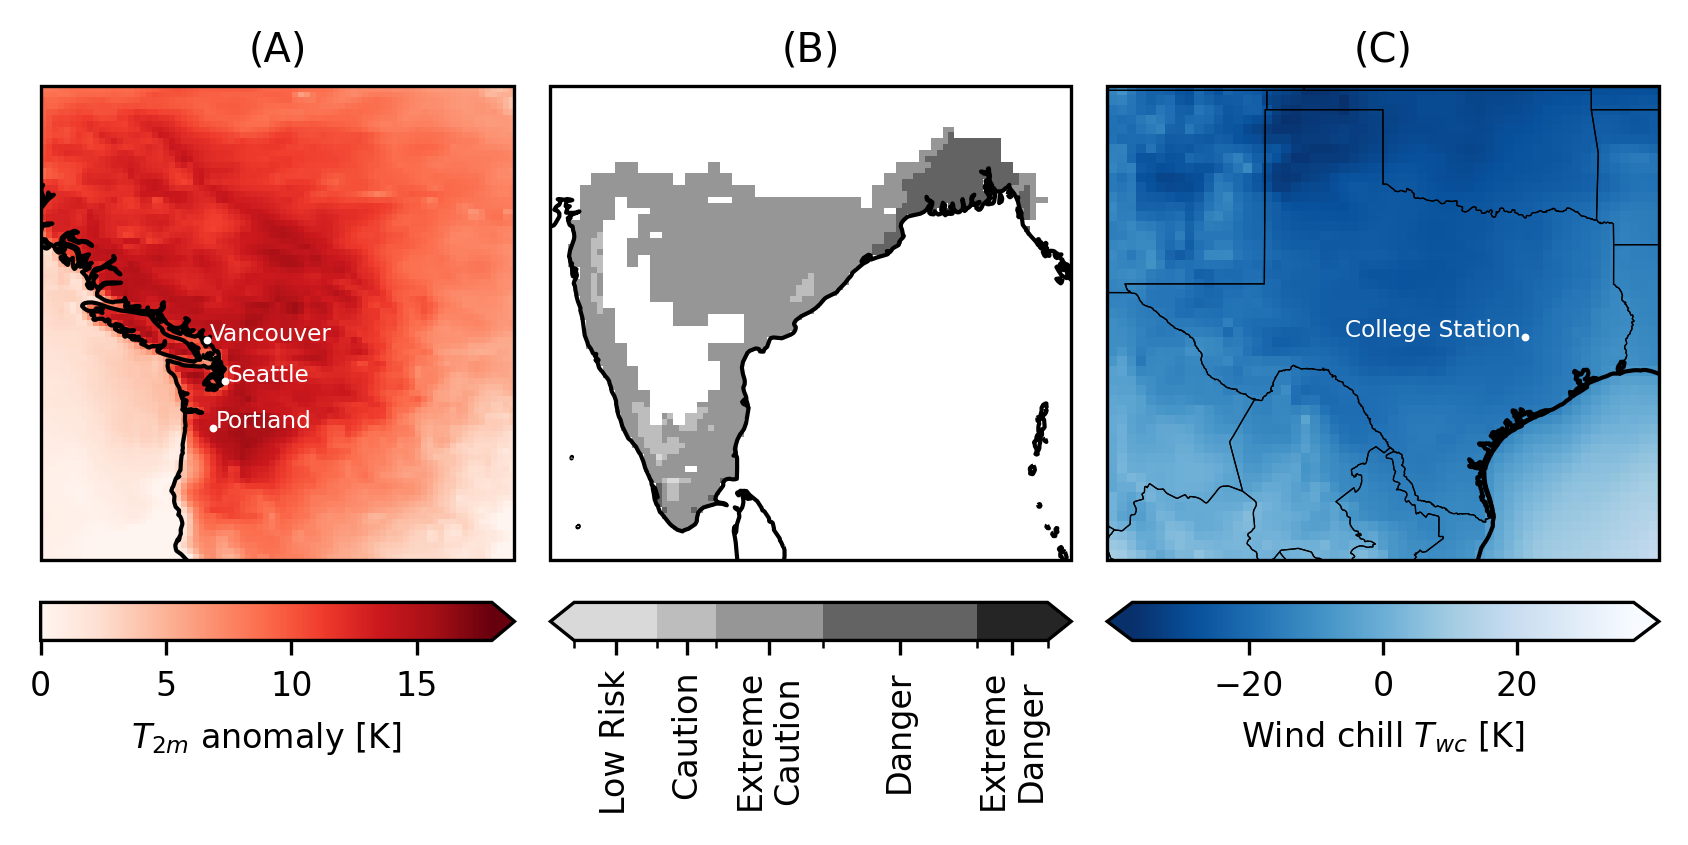

In [12]:
aspect_ratio_single_plot = 0.6

fig = plt.figure(figsize=(textwidth, textwidth / aspect_ratio_single_plot / 3))

gs = gridspec.GridSpec(
    2, 3, figure=fig, height_ratios=[1, 0.05], width_ratios=[1, 1.099, 1.164]
)


# PNW HEATWAVE
anomaly_ERA5 = get_anomaly(
    da=gt_data_pnw.sel(source="ERA5")["2m_temperature"],
    climatology=era5_climatology,
    ts=ts,
)

ax_era5 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
m = (
    anomaly_ERA5["2m_temperature"]
    .mean(dim=("hour", "dayofyear"))
    .plot(ax=ax_era5, add_colorbar=False, cmap="Reds", vmin=0, vmax=18)
)

ax_era5.coastlines()
ax_era5.set_title("(A)")

ax_era5.scatter(
    lons,
    lats,
    transform=ccrs.PlateCarree(),
    c="w",
    marker=".",
    s=3,
    zorder=np.inf,
)

for i, text in enumerate(labels_cities):
    ax_era5.annotate(
        text,
        (lons[i] + 0.1, lats[i]),
        transform=ccrs.PlateCarree(),
        fontsize="x-small",
        color="white",
        zorder=np.inf,
    )

ax_cbar = fig.add_subplot(gs[1, 0])

plt.colorbar(
    m,
    cax=ax_cbar,
    label="$T_{2m}$ anomaly [K]",
    orientation="horizontal",
    extend="max",
)

# HUMID HEAT WAVE

mean_hi_daily_max = mean_daily_max(
    gt_data_humid["heat_index"]
    .sel(source="ERA5", level=1000)
    .sel({"time": slices[0], **boxes[0]})
)

# heat index danger levels
ax = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
cmap = matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ticks = (bounds[1:] - bounds[:-1]) / 2 + bounds[:-1]
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

im_hi_classes = clip_data(mean_hi_daily_max, mask=masks[0]).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
)
ax.coastlines()
ax.set_title("(B)")


ax_cb_hi_classes = plt.subplot(gs[1, 1])
cbar = plt.colorbar(
    mappable=im_hi_classes,
    cax=ax_cb_hi_classes,
    extend="both",
    spacing="proportional",
    ticks=ticks,
    format=fmt,
    orientation="horizontal",
)

cbar.ax.set_xticklabels(labels, rotation=90)

# WINTER STORM
ax = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
im_ws = (
    gt_data_winterstorm["wind_chill"]
    .sel(bb_texas)
    .sel(source="ERA5")
    .sel(time=time_min_winterstorm)
    .plot(ax=ax, cmap="Blues_r", add_colorbar=False)
)  # .sel(bb_texas)

ax.scatter(
    *reversed(list(college_station_coords.values())),
    c="w",
    marker=".",
    s=3,
    zorder=np.inf,
)

ax.annotate(
    "College Station",
    [college_station_coords["longitude"] - 0.1, college_station_coords["latitude"]],
    transform=ccrs.PlateCarree(),
    fontsize="x-small",
    color="white",
    zorder=np.inf,
    horizontalalignment="right",
)

ax.set_title("(C)")
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="k")

ax_cb = plt.subplot(gs[1, 2])
cbar = plt.colorbar(
    mappable=im_ws,
    cax=ax_cb,
    extend="both",
    orientation="horizontal",
    label="Wind chill $T_{wc}$ [K]",
)
plt.tight_layout()
plt.savefig("images/overview.png")